In [75]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import string
import os 
from datetime import datetime
import random
import math

## plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA

import seaborn as sns
sns.set()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import warnings
warnings.filterwarnings('ignore')


## sklearn
import sklearn
from sklearn import preprocessing

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.cross_validation import KFold;
from sklearn.cross_validation import train_test_split

from xgboost import XGBClassifier
from sklearn import tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


# Processing

In [107]:
def preprocess(df):
    # reassign id
#     df.index = df.PassengerId

    # drop not imp data
#     df.drop("PassengerId", axis=1, inplace=True)
    
    # avg_age
#     avg_age = df['Age'].mean()
    avg_age = df['Age'].median()
#     std = df['Age'].std()
#     mean = df['Age'].mean()
#     size = len(df[pd.isnull(df['Age'])])
#     age_null_random_list = np.random.randint(mean - std, mean + std, size=size)
#     df.loc[pd.isnull(df['Age']), 'Age'] = age_null_random_list
    
    # age
#     age_range = list(set(pd.qcut(df[pd.notnull(df['Age'])]['Age'], 5)))
#     def agecat(age):
#         if age in age_range[0]:
#             cat = 0
#         elif age in age_range[1]:
#             cat = 1
#         elif age in age_range[2]:
#             cat = 2
#         elif age in age_range[3]:
#             cat = 3
#         else:
#             cat = 4
#         return cat
    
    def agecat(age):
        if age <= 16:
            cat = 0
        elif age > 16 and age <= 32:
            cat = 1
        elif age > 32 and age <= 48:
            cat = 2
        elif age < 48 and age <= 64:
            cat = 3
        else:
            cat = 4
        return cat
    
    
    # fare
#     fare_range = list(set(pd.qcut(df[pd.notnull(df['Fare'])]['Fare'], 7)))
#     def farecat(f):
#         if f in fare_range[0]:
#             cat = 0
#         elif f in fare_range[1]:
#             cat = 1
#         elif f in fare_range[2]:
#             cat = 2
#         elif f in fare_range[3]:
#             cat = 3
#         elif f in fare_range[4]:
#             cat = 4
#         elif f in fare_range[5]:
#             cat = 5
#         else:
#             cat = 6
#         return cat
    
    
    def farecat(f):
        if f <= 16:
            cat = 0
        elif f > 17 and f <= 32:
            cat = 1
        elif f > 32 and f <= 48:
            cat = 2
        elif f < 48 and f <= 64:
            cat = 3
        elif f < 64 and f <= 80:
            cat = 4
        elif f < 80 and f <= 96:
            cat = 5
        else:
            cat = 6
        return cat

    
    # avg_fare
    fares_notnull = df[pd.notnull(df['Fare'])]['Fare']
    avg_fare = fares_notnull.median()

    # ticket
    ticket_cat = {}
    for ticket in df['Ticket']:
        if ticket.isdigit():
            ticket_cat[ticket] = 1
        elif ticket.startswith('A'):
            ticket_cat[ticket] = 2
        elif ticket.startswith('C'):
            ticket_cat[ticket] = 3
        elif ticket.startswith('F'):
            ticket_cat[ticket] = 4
        elif ticket.startswith('P'):
            ticket_cat[ticket] = 5
        elif ticket.startswith('SOTON'):
            ticket_cat[ticket] = 6
        elif ticket.startswith('STON'):
            ticket_cat[ticket] = 7
        elif ticket.startswith('S'):
            ticket_cat[ticket] = 8
        elif ticket.startswith('W'):
            ticket_cat[ticket] = 9
        else:
            ticket_cat[ticket] = 0
            
    ticket_cat1 = {}
    for num, name in enumerate(list(set([item.split()[0].replace(".", "").replace("/", "") for item in df['Ticket'] if not item.isdigit()]))):
        ticket_cat1[name] = num
    
    # cabin
    cabin_cat = {}
    for cabin in df['Cabin']:
        if pd.isnull(cabin):
            cabin_cat[cabin] = 0
        elif cabin.startswith('A'):
            cabin_cat[cabin] = 1
        elif cabin.startswith('B'):
            cabin_cat[cabin] = 2
        elif cabin.startswith('C'):
            cabin_cat[cabin] = 3
        elif cabin.startswith('D'):
            cabin_cat[cabin] = 4
        elif cabin.startswith('E'):
            cabin_cat[cabin] = 5
        else:
            cabin_cat[cabin] = 0
    
    # embarked
    embarked_cat = {}
    for embarked in df['Embarked']:
        if pd.isnull(embarked):
            embarked_cat[embarked] = 0
        elif embarked.startswith('S'):
            embarked_cat[embarked] = 0
        elif embarked.startswith('Q'):
            embarked_cat[embarked] = 1
        elif embarked.startswith('C'):
            embarked_cat[embarked] = 2
            
            
    # title
    title_mapping= {
        'Ms':"Miss",
        'Mlle':"Miss",
        'Miss':"Miss",
        'Mrs':"Mrs",
        'Mme':"Mrs",
        'MrsMartin(ElizabethL':"Mrs",
        'Mr':"Mr"
        }
    
    title_cat = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    
    # Name_with specail chars
    def withspecailchar(name):
        for char in name:
            if char in string.punctuation:
                return 1
        return 0
    
    def applyfun(row):
        row['Has_Cabin'] = 0 if pd.isnull(row['Cabin']) else 1
        row['Cabin'] = cabin_cat.get(row['Cabin'])

        row['Age'] = row['Age'] if pd.notnull(row['Age']) else avg_age
        row['Age_Cat'] = agecat(row['Age'])
#         row['Age_Lower_than_15'] = 1 if row['Age'] < 15 else 0
#         row['Age_Higher_than_75'] = 1 if row['Age'] > 75 else 0

        row['Fare'] = row['Fare'] if pd.notnull(row['Fare']) else avg_fare
#         row['Fare_log10'] = math.log(row['Fare'], 10) if  row['Fare'] != 0 else 0
        row['Fare_log2'] = math.log(row['Fare'], 2) if  row['Fare'] != 0 else 0

        row['Fare_Cat'] = farecat(row['Fare'])
#         row['High_Price_Fare'] = 1 if row['Fare'] > 200 else 0

        row['Ticket'] = ticket_cat.get(row['Ticket'])
        processed_ticket = row['Ticket'].split()[0].replace(".", "").replace("/", "") if not str(row['Ticket']).isdigit() else None
#         row['Ticket1'] = ticket_cat1.get(processed_ticket) if processed_ticket != None else 30

        row['Embarked'] = embarked_cat.get(row['Embarked'])
        row['Sex'] = 1 if row['Sex'] == 'male' else 0

        row['Name_Length'] = len(row['Name'])
        row['Name_With_Special_Char'] = withspecailchar(row['Name'].replace(',', "").replace('.', ""))
        row['Family_Size'] = row['SibSp'] + row['Parch']
#         row['Is_Alone']= 1 if row['Family_Size'] == 1 else 0
        
        call = re.search(r'\,.+\.', row['Name']).group(0).replace(",", "").replace(".", "").replace(" ", "")
        call_cat = title_cat.get(title_mapping.get(call, "Rare"))
        row['Title'] = call_cat
#         row['Mother'] = 1 if row['Age'] >18 and row['Parch'] > 0 and call != 'Miss' else 0
        return row
    
    df = df.apply(applyfun, axis=1)
    df.drop('Name', axis=1, inplace=True)
    df.drop('Fare', axis=1, inplace=True)
#     df.drop('SibSp', axis=1, inplace=True)
#     df.drop('Parch', axis=1, inplace=True)

    return df

In [92]:
df = pd.read_csv('train.csv')
df = preprocess(df)

count    891.000000
mean       1.256781
std        0.435553
min        0.000000
25%        0.898198
50%        1.159994
75%        1.491362
max        2.709549
Name: Fare_log10, dtype: float64

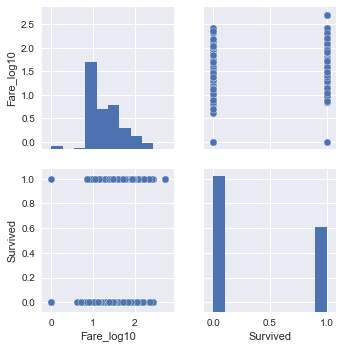

In [146]:
sns.pairplot(df[['Fare_log10', 'Survived']])
df['Fare_log10'].describe()

count    891.000000
mean       4.174938
std        1.446877
min        0.000000
25%        2.983748
50%        3.853417
75%        4.954196
max        9.000927
Name: Fare_log2, dtype: float64

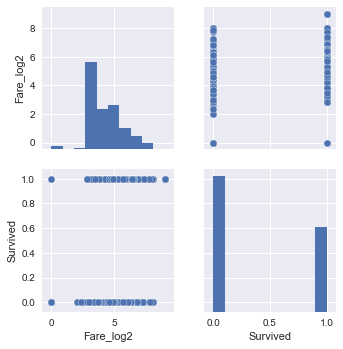

In [147]:
sns.pairplot(df[['Fare_log2', 'Survived']])
df['Fare_log2'].describe()

In [23]:
df.groupby('Ticket').mean()['Survived']

Ticket
0    0.250000
1    0.384266
2    0.068966
3    0.340426
4    0.571429
5    0.646154
6    0.117647
7    0.444444
8    0.366667
9    0.153846
Name: Survived, dtype: float64

In [195]:
df.groupby('Is_Alone').mean()['Survived']

Is_Alone
0    0.346575
1    0.552795
Name: Survived, dtype: float64

In [153]:
df.groupby('Fare_Cat').mean()['Survived']
df.groupby('Cabin').mean()['Survived']
df.groupby('Has_Cabin').mean()['Survived']
df.groupby('Name_With_Special_Char').count()['Survived']

# lowerbound = 15
# upperbound = 16
# print(df[df['Age'] >= lowerbound][df['Age'] < upperbound]['Survived'].mean())
# print(df[df['Age'] >= lowerbound][df['Age'] < upperbound]['Survived'].count())

Name_With_Special_Char
0    697
1    194
Name: Survived, dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 20 columns):
PassengerId           891 non-null int64
Survived              891 non-null int64
Pclass                891 non-null int64
Sex                   891 non-null int64
Age                   891 non-null float64
SibSp                 891 non-null int64
Parch                 891 non-null int64
Ticket                891 non-null int64
Fare                  891 non-null float64
Cabin                 891 non-null int64
Embarked              891 non-null int64
Has_Cabin             891 non-null int64
Age_Cat               891 non-null int64
Age_Lower_than_15     891 non-null int64
Age_Higher_than_75    891 non-null int64
Name_Length           891 non-null int64
Family_Size           891 non-null int64
Is_Alone              891 non-null int64
High_Price_Fare       891 non-null int64
Title                 891 non-null int64
dtypes: float64(2), int64(18)
memory usage: 139.3 KB


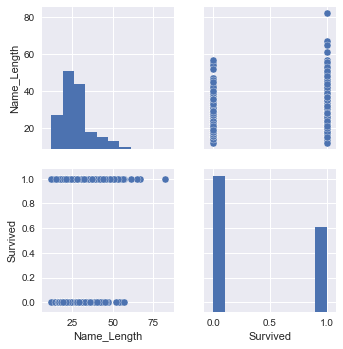

In [158]:
df.info()
sns.pairplot(df[['Name_Length', 'Survived']])

In [211]:
# df1 = df[df['Cabin']==0]
# sum(df1[df1['Survived']==1]['Survived']) / len(df1)


# df1 = df[df['Fare']<0][df['Fare']>30]
# (df1[df1['Survived']==1]['Fare']).count() / len(df1)

# df1 = df[df['Sex'] == 0][df['Age'] > 20][df['Age'] < 80]
# print(len(df1))
# (df1[df1['Survived']==1]['Fare']).count() / len(df1)

df1 = df.groupby('Sex')['Survived'].mean()
df1


# plt.hist(df['Fare'])

Sex
0    0.742038
1    0.188908
Name: Survived, dtype: float64

In [24]:
# 40 in list(set(pd.qcut(df['Age'], 4)))[0]
list(set(pd.qcut(df['Age'], 4)))

[nan,
 Interval(28.0, 38.0, closed='right'),
 Interval(38.0, 80.0, closed='right'),
 Interval(20.125, 28.0, closed='right'),
 Interval(0.41899999999999998, 20.125, closed='right')]

# unsemble skill

In [108]:
# Input Data Preparation
df = pd.read_csv('train.csv')
df = preprocess(df)
x_train = np.matrix(df.drop(['Survived','PassengerId'], axis=1))
y_train = np.array(df['Survived'])

df_test = pd.read_csv('test.csv')
ID = df_test['PassengerId']
x_test = np.matrix(preprocess(df_test.drop('PassengerId', axis=1)))

print(y_train.shape)
print(x_train.shape)
print(x_test.shape)

(891,)
(891, 16)
(418, 16)


In [109]:
# Some useful parameters which will come in handy later on
ntrain = df.shape[0]
ntest = df_test.shape[0]
SEED = 0 # for reproducibility
NFOLDS = 5 # set folds for out-of-fold prediction
kf = KFold(ntrain, n_folds= NFOLDS, random_state=SEED)

# Class to extend the Sklearn classifier
class SklearnHelper(object):
    def __init__(self, clf, seed=0, params=None):
        if seed == 0:
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def fit(self,x,y):
        return self.clf.fit(x,y)
    
    def feature_importances(self,x,y):
        print(self.clf.fit(x,y).feature_importances_)
    
# Class to extend XGboost classifer

In [110]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))

    for i, (train_index, test_index) in enumerate(kf):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]

        clf.train(x_tr, y_tr)

        oof_train[test_index] = clf.predict(x_te)  ## 這裡的test set應是指dev set
        oof_test_skf[i, :] = clf.predict(x_test)  ##真實的test set

    oof_test[:] = oof_test_skf.mean(axis=0)
    accuracy = np.sum(oof_train == y_train)/len(oof_train)

    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1), accuracy

In [111]:
# Put in our parameters for said classifiers
# Random Forest parameters
rf_params = {'criterion': 'gini',
   'max_depth': 5,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'n_estimators': 190,
   'n_jobs': -1,
   'verbose': 0,
   'warm_start': True}

# Extra Trees Parameters
et_params =  {'max_depth': 10,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'n_estimators': 200,
   'n_jobs': -1,
   'verbose': 0}

# AdaBoost parameters
ada_params = {'algorithm': 'SAMME',
   'learning_rate': 0.45,
   'n_estimators': 120}

# Gradient Boosting parameters
gb_params = {'max_depth': 50,
   'max_features': 'sqrt',
   'min_samples_leaf': 2,
   'n_estimators': 2500,
   'verbose': 0}

# Support Vector Classifier parameters 
svc_params = {
    'kernel' : 'linear',
    'C' : 1
    }

# XGB Classifier parameters 
xgb_params = {
    'learning_rate' : 0.4
    }

# Decision Tree parameters
dt_params = {
    "criterion":"entropy"
}

# Naïve Bayes
nb_params ={
    
}

# K nearest neighbor
knn_params = {
    "n_neighbors":5
}

In [116]:
# Create 5 objects that represent our 4 models
rf = SklearnHelper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
et = SklearnHelper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
ada = SklearnHelper(clf=AdaBoostClassifier, seed=SEED, params=ada_params)
gb = SklearnHelper(clf=GradientBoostingClassifier, seed=SEED, params=gb_params)
svc = SklearnHelper(clf=SVC, seed=SEED, params=svc_params)

xgb = SklearnHelper(clf=XGBClassifier, seed=1, params=xgb_params)
dt = SklearnHelper(clf=tree.DecisionTreeClassifier, seed=SEED, params=dt_params)
nb = SklearnHelper(clf=GaussianNB, seed=1, params=nb_params)
knn = SklearnHelper(clf=KNeighborsClassifier, seed=1, params=knn_params)

In [117]:
# Create our OOF train and test predictions. These base results will be used as new features
rf_oof_train, rf_oof_test, rf_accuracy = get_oof(rf,x_train, y_train, x_test) # Random Forest
et_oof_train, et_oof_test, et_accuracy = get_oof(et, x_train, y_train, x_test) # Extra Trees
ada_oof_train, ada_oof_test, ada_accuracy = get_oof(ada, x_train, y_train, x_test) # AdaBoost 
gb_oof_train, gb_oof_test, gb_accuracy = get_oof(gb,x_train, y_train, x_test) # Gradient Boost
svc_oof_train, svc_oof_test, svc_accuracy = get_oof(svc,x_train, y_train, x_test) # Support Vector Classifier


xgb_oof_train, xgb_oof_test, xgb_accuracy = get_oof(xgb,x_train, y_train, x_test) # XGB Classifier
dt_oof_train, dt_oof_test, dt_accuracy = get_oof(dt,x_train, y_train, x_test) # decision tree Classifier
nb_oof_train, nb_oof_test, nb_accuracy = get_oof(nb,x_train, y_train, x_test) # Naïve Bayes Classifier
knn_oof_train, knn_oof_test, knn_accuracy = get_oof(knn,x_train, y_train, x_test) # K nearest neighbor Classifier

print("Training is complete")

Training is complete


In [118]:
print("Training Set Number: {}".format(x_train.shape[0]))
print("- Random Forest: {}".format((y_train != rf_oof_train.reshape(y_train.shape)).sum()))
print("- Extra Trees: {}".format((y_train != et_oof_train.reshape(y_train.shape)).sum()))
print("- AdaBoost parameters: {}".format((y_train != ada_oof_train.reshape(y_train.shape)).sum()))
print("- Gradient Boosting : {}".format((y_train != gb_oof_train.reshape(y_train.shape)).sum()))
print("- SVM: {}".format((y_train != svc_oof_train.reshape(y_train.shape)).sum()))

# print("- XGBoost: {}".format((y_train != xgb_oof_train.reshape(y_train.shape)).sum()))
# print("- Decision tree: {}".format((y_train != dt_oof_train.reshape(y_train.shape)).sum()))
# print("- Naïve Bayes: {}".format((y_train != nb_oof_train.reshape(y_train.shape)).sum()))
# print("- K Nearest Neighbor: {}".format((y_train != knn_oof_train.reshape(y_train.shape)).sum()))

print("Accuracy")
print("- Random Forest", rf_accuracy)
print("- Extra Trees", et_accuracy)
print("- AdaBoost", ada_accuracy)
print("- Gradient Boosting", gb_accuracy)
print("- SVM", svc_accuracy)


print("- Xgboost", xgb_accuracy)
print("- Decision Tree", dt_accuracy)
print("- Naïve Bayes", nb_accuracy)
print("- K Nearest Neighbor", knn_accuracy)




Training Set Number: 891
- Random Forest: 124
- Extra Trees: 157
- AdaBoost parameters: 165
- Gradient Boosting : 165
- SVM: 170
Accuracy
- Random Forest 0.860830527497
- Extra Trees 0.82379349046
- AdaBoost 0.814814814815
- Gradient Boosting 0.814814814815
- SVM 0.809203142536
- Xgboost 0.827160493827
- Decision Tree 0.760942760943
- Naïve Bayes 0.773288439955
- K Nearest Neighbor 0.741863075196


- Training Set Number: 891
- Random Forest: 118
- Extra Trees: 162
- AdaBoost parameters: 175
- Gradient Boosting : 170
- SVM: 167


Training Set Number: 891
- Random Forest: 114
- Extra Trees: 156
- AdaBoost parameters: 175
- Gradient Boosting : 168
- SVM: 167
- XGBoost: 155
- Decision tree: 226
- Naïve Bayes: 222
- K Nearest Neighbor: 252


Training Set Number: 891
- Random Forest: 113
- Extra Trees: 161
- AdaBoost parameters: 175
- Gradient Boosting : 171
- SVM: 167
- XGBoost: 155
- Decision tree: 209
- Naïve Bayes: 222
- K Nearest Neighbor: 252

Accuracy
- Random Forest 0.92480359147
- Extra Trees 0.830527497194
- AdaBoost 0.820426487093
- Gradient Boosting 0.81593714927
- SVM 0.833894500561

Accuracy
- Random Forest 0.861952861953
- Extra Trees 0.824915824916
- AdaBoost 0.814814814815
- Gradient Boosting 0.808080808081
- SVM 0.811447811448

# Prediction

In [119]:
x_train_concat = np.concatenate(( et_oof_train, 
                          rf_oof_train, 
                          ada_oof_train, 
                          gb_oof_train, 
                          svc_oof_train, 
#                           xgb_oof_train, 
#                           dt_oof_train, 
#                           nb_oof_train, 
#                           knn_oof_train,
                          x_train
                         ), axis=1)
x_test_concat = np.concatenate(( et_oof_test, 
                         rf_oof_test, 
                         ada_oof_test, 
                         gb_oof_test, 
                         svc_oof_test, 
#                          xgb_oof_test, 
#                          dt_oof_test, 
#                          nb_oof_test, 
#                          knn_oof_test,
                         x_test
                        ), axis=1)


In [120]:
# Finally, we split some of the data off for validation
x_train_split, x_valid_split, y_train_split, y_valid_split = train_test_split(x_train_concat, y_train, test_size=0.4, random_state=4242)

print(x_train_split.shape)
print(x_valid_split.shape)
print(y_train_split.shape)
print(y_valid_split.shape)

(534, 21)
(357, 21)
(534,)
(357,)


In [121]:
import xgboost

# Set our parameters for xgboost
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.04
params['max_depth'] = 3
params['learning_rate'] = 0.01

## control over-fitting, higher depth specific to a particular sample.
d_train = xgboost.DMatrix(x_train_split, label=y_train_split)
d_valid = xgboost.DMatrix(x_valid_split, label=y_valid_split)

watchlist = [(d_train, 'train'), (d_valid, 'valid')]

bst = xgboost.train(params, d_train, 1000, watchlist, early_stopping_rounds=100, verbose_eval=10)

[0]	train-logloss:0.687551	valid-logloss:0.687765
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 100 rounds.
[10]	train-logloss:0.637101	valid-logloss:0.639819
[20]	train-logloss:0.595107	valid-logloss:0.600466
[30]	train-logloss:0.559799	valid-logloss:0.567589
[40]	train-logloss:0.529861	valid-logloss:0.539786
[50]	train-logloss:0.504314	valid-logloss:0.516184
[60]	train-logloss:0.482407	valid-logloss:0.496042
[70]	train-logloss:0.463538	valid-logloss:0.478803
[80]	train-logloss:0.447237	valid-logloss:0.464118
[90]	train-logloss:0.433116	valid-logloss:0.451609
[100]	train-logloss:0.420629	valid-logloss:0.44067
[110]	train-logloss:0.409694	valid-logloss:0.431273
[120]	train-logloss:0.400105	valid-logloss:0.423235
[130]	train-logloss:0.391663	valid-logloss:0.41656
[140]	train-logloss:0.384145	valid-logloss:0.411155
[150]	train-logloss:0.377138	valid-logloss:0.407249
[160]	train-logloss:0.370736	

In [103]:
# df_score = pd.DataFrame()
# df_score.columns = ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
#        'Ticket', 'Fare', 'Cabin', 'Embarked', 'Has_Cabin', 'Age_Cat',
#        'Age_Lower_than_15', 'Age_Higher_than_75', 'Fare_log10', 'Fare_log2',
#        'Fare_Cat', 'High_Price_Fare', 'Name_Length', 'Name_With_Special_Char',
#        'Family_Size', 'Is_Alone', 'Title', 'Mother']

# insert_row = {}
# set(df_score.columns) & set(df.columns )
# ['PassengerId', 'Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch',
#        'Ticket', 'Cabin', 'Embarked', 'Has_Cabin', 'Age_Cat', 'Fare_log2',
#        'Fare_Cat', 'Name_Length', 'Name_With_Special_Char', 'Family_Size',
#        'Title'] 0.388

In [ ]:
y_pred = bst.predict(xgboost.DMatrix(x_valid_split))
print("Number of mislabeled points out of a total %d points : %d" % (x_valid_split.shape[0],(y_valid_split != (y_pred > 0.5)).sum()))

In [36]:
predictions = (bst.predict(xgboost.DMatrix(x_test_concat)) > 0.5) * 1
# print("Number of mislabeled points out of a total %d points : %d" % (x_valid.shape[0],(y_valid != (y_pred > 0.5)).sum()))

In [37]:
# Generate Submission File 

StackingSubmission = pd.DataFrame({ 'PassengerId': ID, 'Survived': predictions })

nowtime = str(datetime.now())
for char in string.punctuation:
    nowtime = nowtime.replace(char, "").replace(" ", "")

filename = os.path.join("submission", nowtime[:14]+"StackingSubmission.csv")
StackingSubmission.to_csv(filename, index=False)

In [51]:
df_check = pd.np.concatenate(
               (x_valid_split, 
                ((y_pred>0.5)*1).reshape(len(y_valid_split), 1), 
                y_valid_split.reshape(len(y_valid_split), 1)),
    axis=1)

columns = ['et', 'rf', 'ada', 'gb', 'svc']
columns.extend(list(df.drop(['Survived','PassengerId'], axis=1).columns))
columns.extend(['y_pred', 'y_label'])

df_check = pd.DataFrame(df_check)
df_check.columns = columns
df_check


columns = list(df.drop(['Survived','PassengerId'], axis=1).columns)
columns.extend(['y_pred', 'y_label'])
df_false_classfied = df_check[df_check['y_pred'] != df_check['y_label']][columns]

showing_columns = list(df.drop(['Survived','PassengerId'], axis=1).columns)

In [52]:
df_false_classfied[df_false_classfied['y_label'] == 1].describe()[showing_columns]
df_false_classfied[df_false_classfied['y_label'] == 1]
# 誤判為死亡
# male
# familt_size = 0.481481(small size)
# Is_Alone = 0.111111
# doesn't hascabin




,Pclass,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Has_Cabin,Age_Cat,...,Fare_log2,Fare_Cat,High_Price_Fare,Name_Length,Name_With_Special_Char,Family_Size,Is_Alone,Title,y_pred,y_label
1,2.0,1.0,62.0,0.0,0.0,8.0,0.0,0.0,0.0,4.0,...,3.392317,0.0,0.0,18.0,0.0,0.0,0.0,1.0,0.0,1.0
2,3.0,1.0,32.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,5.820072,4.0,0.0,13.0,0.0,0.0,0.0,1.0,0.0,1.0
14,3.0,1.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.000000,0.0,0.0,28.0,0.0,0.0,0.0,1.0,0.0,1.0
24,3.0,1.0,28.0,2.0,0.0,1.0,0.0,1.0,0.0,1.0,...,4.539159,1.0,0.0,18.0,0.0,2.0,0.0,1.0,0.0,1.0
30,3.0,1.0,28.0,1.0,1.0,1.0,0.0,2.0,0.0,1.0,...,3.930340,0.0,0.0,24.0,0.0,2.0,0.0,5.0,0.0,1.0
42,3.0,1.0,32.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,2.973464,0.0,0.0,17.0,0.0,0.0,0.0,1.0,0.0,1.0
53,3.0,0.0,31.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,3.118243,0.0,0.0,16.0,0.0,0.0,0.0,3.0,0.0,1.0
68,3.0,1.0,20.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,...,2.853836,0.0,0.0,21.0,0.0,0.0,0.0,1.0,0.0,1.0
79,3.0,1.0,29.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,2.954196,0.0,0.0,24.0,0.0,0.0,0.0,1.0,0.0,1.0
96,3.0,1.0,22.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,...,2.852998,0.0,0.0,33.0,1.0,0.0,0.0,1.0,0.0,1.0


In [53]:
df_false_classfied[df_false_classfied['y_label'] == 0].describe()[showing_columns]

# description: people ultimatly not survived are classified as survived(誤判為存活)
# female 
# family_size = 1.187500（big size）
# Is_Alone = 0.500000
# has cabin

,Pclass,Sex,Age,SibSp,Parch,Ticket,Cabin,Embarked,Has_Cabin,Age_Cat,Age_Lower_than_15,Age_Higher_than_75,Fare_log2,Fare_Cat,High_Price_Fare,Name_Length,Name_With_Special_Char,Family_Size,Is_Alone,Title
count,20.000000,20.000000,20.000000,20.000000,20.00000,20.000000,20.000000,20.000000,20.000000,20.000000,20.0,20.0,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,2.300000,0.200000,32.525000,0.700000,0.25000,2.450000,1.050000,0.700000,0.300000,1.600000,0.0,0.0,4.256114,1.250000,0.050000,32.850000,0.500000,0.950000,0.400000,2.400000
std,0.801315,0.410391,11.454113,0.801315,0.55012,2.459675,1.700619,0.864505,0.470162,0.940325,0.0,0.0,1.386118,2.173404,0.223607,12.612755,0.512989,1.190975,0.502625,0.940325
min,1.000000,0.000000,18.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,2.754888,0.000000,0.000000,17.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,26.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,3.355270,0.000000,0.000000,21.750000,0.000000,0.000000,0.000000,2.000000
50%,2.500000,0.000000,28.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,3.853417,0.000000,0.000000,29.000000,0.500000,1.000000,0.000000,2.000000
75%,3.000000,0.000000,41.000000,1.000000,0.00000,2.750000,3.000000,1.250000,1.000000,2.000000,0.0,0.0,4.700440,1.000000,0.000000,45.250000,1.000000,1.000000,1.000000,3.000000
max,3.000000,1.000000,57.000000,3.000000,2.00000,8.000000,5.000000,2.000000,1.000000,4.000000,0.0,0.0,8.038919,6.000000,1.000000,56.000000,1.000000,5.000000,1.000000,5.000000


In [54]:
x_valid_split.shape
len(list(df.drop(['Survived','PassengerId'], axis=1).columns))
list(df.drop(['Survived','PassengerId'], axis=1).columns)
x_train_concat.shape
x_train.shape

(891, 20)

In [141]:
y_valid_split.shape
# ((y_pred>0.5)*1).shape

(357,)

1. 0.66985: SVM + original feature => XGB
2. 0.73205: add feature(namelength  + title(ex. Miss) + cabin_binary) => SVM + original feature => XGB
3. 0.79425: same feature => (random forest + extra tree + Gradient Boosting + SVC) with cross-validate => XGB
4. 0.80382: same feature => (random forest + extra tree + Gradient Boosting + SVC) with cross-validate => XGB with cross-validate
5. 0.79904: same feature => (random forest + extra tree + Gradient Boosting + SVC + XGB + KNN + decision tree + Naïve Bayes) with cross-validate => XGB with cross-validate

In [352]:
os.listdir('submission')

['20171111211119StackingSubmission.csv',
 '20171111214007StackingSubmission.csv',
 'gender_submission.csv',
 'h_StackingSubmission.csv',
 'StackingSubmission.csv',
 'submission.ipynb',
 'submit.csv']

In [374]:
path = os.path.join("submission", 'h_StackingSubmission.csv')
df_reverse0 = pd.read_csv(path)
df_reverse0.columns = ["PassengerId", "8032"]

path = os.path.join("submission", '20171111214007StackingSubmission.csv')
df_reverse1 = pd.read_csv(path)
df_reverse1.drop("PassengerId", axis=1, inplace=True)
df_reverse1.columns = ["7799"]

path = os.path.join("submission", '20171111211119StackingSubmission.csv')
df_reverse2 = pd.read_csv(path)
df_reverse2.drop("PassengerId", axis=1, inplace=True)
df_reverse2.columns = ["7703"]

df_reverse = pd.concat([df_reverse0, df_reverse1, df_reverse2], axis=1)
len(df_reverse[df_reverse['8032'] != df_reverse['7799']])

15

In [372]:
len(df_reverse) * (1-0.8032)

82.26239999999999

# Features

In [104]:
rf_feature = rf.feature_importances(x_train,y_train)
et_feature = et.feature_importances(x_train, y_train)
ada_feature = ada.feature_importances(x_train, y_train)
gb_feature = gb.feature_importances(x_train,y_train)

# xgb_feature = xgb.feature_importances(x_train,y_train)
# dt_feature = dt.feature_importances(x_train, y_train)
# nb_feature = nb.feature_importances(x_train, y_train)
# knn_feature = knn.feature_importances(x_train,y_train)

[ 0.07255116  0.17052093  0.04345239  0.02108023  0.0127789   0.01514993
  0.06801336  0.04786571  0.00972451  0.02522593  0.01229409  0.00983875
  0.          0.07219645  0.03608945  0.00116443  0.04711424  0.05888067
  0.04601227  0.00435038  0.22353933  0.00215691]
[ 0.08625507  0.28099488  0.02293435  0.02776079  0.01573817  0.01611234
  0.02301345  0.0376296   0.02218959  0.05061587  0.01826265  0.02338628
  0.          0.03373806  0.03601605  0.00210759  0.03087182  0.09618422
  0.03244529  0.00807824  0.12576521  0.00990046]
[ 0.04671695  0.08600482  0.12816004  0.          0.          0.03509325
  0.01705068  0.10087001  0.01151157  0.          0.          0.          0.
  0.06705437  0.          0.          0.          0.0605908   0.30855795
  0.          0.13838956  0.        ]
[  2.81130637e-03   3.30138819e-02   2.25753020e-01   1.11955032e-02
   9.61649205e-03   9.30116835e-02   8.72010940e-02   1.54240939e-02
   8.68205056e-03   5.14277712e-03   3.65361183e-02   1.7602231

In [106]:
AA = """[ 0.06932811  0.17884546  0.05447127  0.0187283   0.04698694  0.01397682
  0.04500766  0.01775047  0.09438059  0.04687398  0.00072783  0.06393494
  0.05258158  0.04890289  0.24750315]
[ 0.09292226  0.29074079  0.03478296  0.01955608  0.03371181  0.02601308
  0.06490612  0.02783662  0.03753288  0.04291942  0.00327214  0.03847315
  0.11216327  0.04154303  0.13362639]
[ 0.04671695  0.08600482  0.12816004  0.03509325  0.10087001  0.01151157
  0.          0.          0.08410504  0.          0.          0.          0.0605908
  0.30855795  0.13838956]
[ 0.03266793  0.05886915  0.23245399  0.07432513  0.01954384  0.00066229
  0.00731015  0.02463534  0.12788754  0.01482779  0.00119238  0.2695961
  0.03474041  0.02862579  0.05306217]"""


AA = """[ 0.0654252   0.17918048  0.0366758   0.02312648  0.01402205  0.01456903
  0.0721418   0.03666305  0.01144376  0.02920926  0.01118115  0.0135511   0.
  0.07795659  0.06291805  0.01815778  0.0006236   0.04784195  0.05243076
  0.03858778  0.00239984  0.18888703  0.00300747]
[ 0.07863707  0.28769044  0.02335804  0.02517831  0.0177478   0.01570826
  0.0253612   0.03288204  0.02182787  0.05674996  0.01921817  0.0234994   0.
  0.02922065  0.0291085   0.03418861  0.00247922  0.03024197  0.10104044
  0.03145743  0.00895235  0.09608476  0.00936751]
[ 0.04671695  0.08600482  0.12816004  0.          0.          0.03509325
  0.04622387  0.10087001  0.01151157  0.          0.          0.          0.
  0.03512731  0.00275387  0.          0.          0.          0.0605908
  0.30855795  0.          0.13838956  0.        ]
[  1.89633351e+00   1.36168351e-02   7.67920535e+00   1.28278423e-02
   1.19644807e-01   5.73394934e-01   5.09636817e-02   9.23463415e-03
  -2.79679052e+00  -1.84984862e+01   1.96161666e-01   2.06630362e-03
   0.00000000e+00   1.15976911e-01   3.55650126e+00  -5.68447712e-03
   1.81178919e-04   3.13540966e+00   1.33418485e-02   8.85673384e-03
   2.63084723e-01   4.58289773e+00   4.06162785e-03]"""
AA= AA.replace(']', ' ]').replace('\n', '').replace('  ', ',')
for li in re.findall(r'\[.+?\]', AA):
    print(eval(li))
# features_Li = []

# for item in re.findall(r'\[.+?\]', AA):
#     nums = np.array(re.findall(r'0\..+? ', item)).astype(float)
#     features_Li.append(nums)
#     print(len(nums))
#     print(nums)

[0.0654252, 0.17918048, 0.0366758, 0.02312648, 0.01402205, 0.01456903, 0.0721418, 0.03666305, 0.01144376, 0.02920926, 0.01118115, 0.0135511, 0.0, 0.07795659, 0.06291805, 0.01815778, 0.0006236, 0.04784195, 0.05243076, 0.03858778, 0.00239984, 0.18888703, 0.00300747]
[0.07863707, 0.28769044, 0.02335804, 0.02517831, 0.0177478, 0.01570826, 0.0253612, 0.03288204, 0.02182787, 0.05674996, 0.01921817, 0.0234994, 0.0, 0.02922065, 0.0291085, 0.03418861, 0.00247922, 0.03024197, 0.10104044, 0.03145743, 0.00895235, 0.09608476, 0.00936751]


SyntaxError: invalid syntax (<string>, line 1)

In [40]:
rf_features = features_Li[0]
et_features = features_Li[1]
ada_features = features_Li[2]
gb_features = features_Li[3]

In [41]:
cols = df.drop(['Survived','PassengerId'], axis=1).columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

In [42]:
# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Random Forest feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Random Forest feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Random Forest Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Extra Trees  feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Extra Trees  feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Extra Trees Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['AdaBoost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['AdaBoost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'AdaBoost Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

# Scatter plot 
trace = go.Scatter(
    y = feature_dataframe['Gradient Boost feature importances'].values,
    x = feature_dataframe['features'].values,
    mode='markers',
    marker=dict(
        sizemode = 'diameter',
        sizeref = 1,
        size = 25,
#       size= feature_dataframe['AdaBoost feature importances'].values,
        #color = np.random.randn(500), #set color equal to a variable
        color = feature_dataframe['Gradient Boost feature importances'].values,
        colorscale='Portland',
        showscale=True
    ),
    text = feature_dataframe['features'].values
)
data = [trace]

layout= go.Layout(
    autosize= True,
    title= 'Gradient Boosting Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig,filename='scatter2010')

In [43]:
# Create the new column containing the average of values
feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

,AdaBoost feature importances,Extra Trees feature importances,Gradient Boost feature importances,Random Forest feature importances,features,mean
0,0.046717,0.092922,0.032668,0.069328,Pclass,0.060409
1,0.086005,0.290741,0.058869,0.178845,Sex,0.153615
2,0.128160,0.034783,0.232454,0.054471,Age,0.112467


In [44]:
y = feature_dataframe['mean'].values
x = feature_dataframe['features'].values
data = [go.Bar(
            x= x,
             y= y,
            width = 0.5,
            marker=dict(
               color = feature_dataframe['mean'].values,
            colorscale='Portland',
            showscale=True,
            reversescale = False
            ),
            opacity=0.6
        )]

layout= go.Layout(
    autosize= True,
    title= 'Barplots of Mean Feature Importance',
    hovermode= 'closest',
#     xaxis= dict(
#         title= 'Pop',
#         ticklen= 5,
#         zeroline= False,
#         gridwidth= 2,
#     ),
    yaxis=dict(
        title= 'Feature Importance',
        ticklen= 5,
        gridwidth= 2
    ),
    showlegend= False
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='bar-direct-labels')

In [62]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

,AdaBoost,ExtraTrees,GradientBoost,RandomForest
0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0
2,0.0,0.0,1.0,0.0
3,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0


In [67]:
data = [
    go.Heatmap(
        z= base_predictions_train.astype(float).corr().values ,
        x=base_predictions_train.columns.values,
        y= base_predictions_train.columns.values,
          colorscale='Viridis',
            showscale=True,
            reversescale = True
    )
]
py.iplot(data, filename='labelled-heatmap')